# Import Model

In [2]:
from python_scripts.pretrain_model import PretrainedEncoderRegressor
import torch.nn as nn

name = 'AE_Center_noaug'

checkpoint_path = f"AE_model/version2/{name}/best.pt"

# 1) 实例化（会自动加载并冻结 encoder）
model = PretrainedEncoderRegressor(
    ae_checkpoint=checkpoint_path,
    ae_type="center",
    center_dim=64, neighbor_dim=64, hidden_dim=128,
    tile_size=26, output_dim=35,
    freeze_encoder = True
)

# 2) monkey‐patch 一个新的 head
model.decoder  = nn.Sequential(
    nn.Linear(64+64, 256),
    nn.SiLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 128),
    nn.SiLU(),
    nn.Dropout(0.1),
    nn.Linear(128, 64),
    nn.SiLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 35)
    
)

# 3) 再次检查只训练 head
# for name, p in model.named_parameters():
#     print(name, p.requires_grad)



# —— 5) 确保只有 decoder 可训练 ——  
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable / total params = {trainable:,} / {total:,}")


Trainable / total params = 76,451 / 1,130,787


## Load Model

# Import training data

## Same in multiple .pt

In [3]:
import os
import torch
import random
import inspect
from python_scripts.import_data import load_all_tile_data

# 用法範例
#folder = "dataset/spot-rank/version-3/only_tile_sub/original_train"
folder = "dataset/spot-rank/filtered_directly_rank/masked/realign/Macenko_masked/filtered/train_data/"

grouped_data = load_all_tile_data( 
        folder_path=folder,
        model=model,
        fraction=1,
        shuffle=False
    )

    # grouped_data 現在只會有 model.forward() 需要的 key，
    # 像 ['tile','subtiles','neighbors','norm_coord','node_feat','adj_list','edge_feat','label','source_idx']
print("Loaded keys:", grouped_data.keys())
print("Samples:", len(next(iter(grouped_data.values()))))


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/deweywang/Desktop/GitHub/HEVisum/python_scripts/import_data.py:287: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_

Loaded keys: dict_keys(['subtiles', 'source_idx', 'label', 'tile', 'slide_idx'])
Samples: 8348


In [7]:
import os
import torch
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from python_scripts.operate_model import train_one_epoch, evaluate, predict, plot_losses, plot_per_cell_metrics,spear_EarlyStopping
import torch.nn as nn

# ---------------------------
# 指定儲存資料夾
# ---------------------------
save_folder = f"/Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/{name}/filtered_directly_rank/k-fold/realign_all/Macenko_masked/"  # 修改為你想要的資料夾名稱
if not os.path.exists(save_folder):   
    os.makedirs(save_folder)


In [8]:
# --------------------------------------------
# 2) 從 grouped_data 取出 slide_idx，轉成 numpy
# --------------------------------------------
import numpy as np
slide_idx = np.array(grouped_data['slide_idx'])   # shape (N,)

# --------------------------------------------
# 3) 建立 LOGO（或改成 GroupKFold）
# --------------------------------------------
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()

# X 可以給虛擬矩陣，因為分組只靠 groups
X_dummy = np.zeros(len(slide_idx))
X_dummy

array([0., 0., 0., ..., 0., 0., 0.])

EarlyStopping counter: 15/15
[Epoch 22]  lr=8.36e-05, train_loss=40.8067, val_loss=74.6872
train spearman: 0.7740 | Val spearman: 0.5527 | best: 0.5919


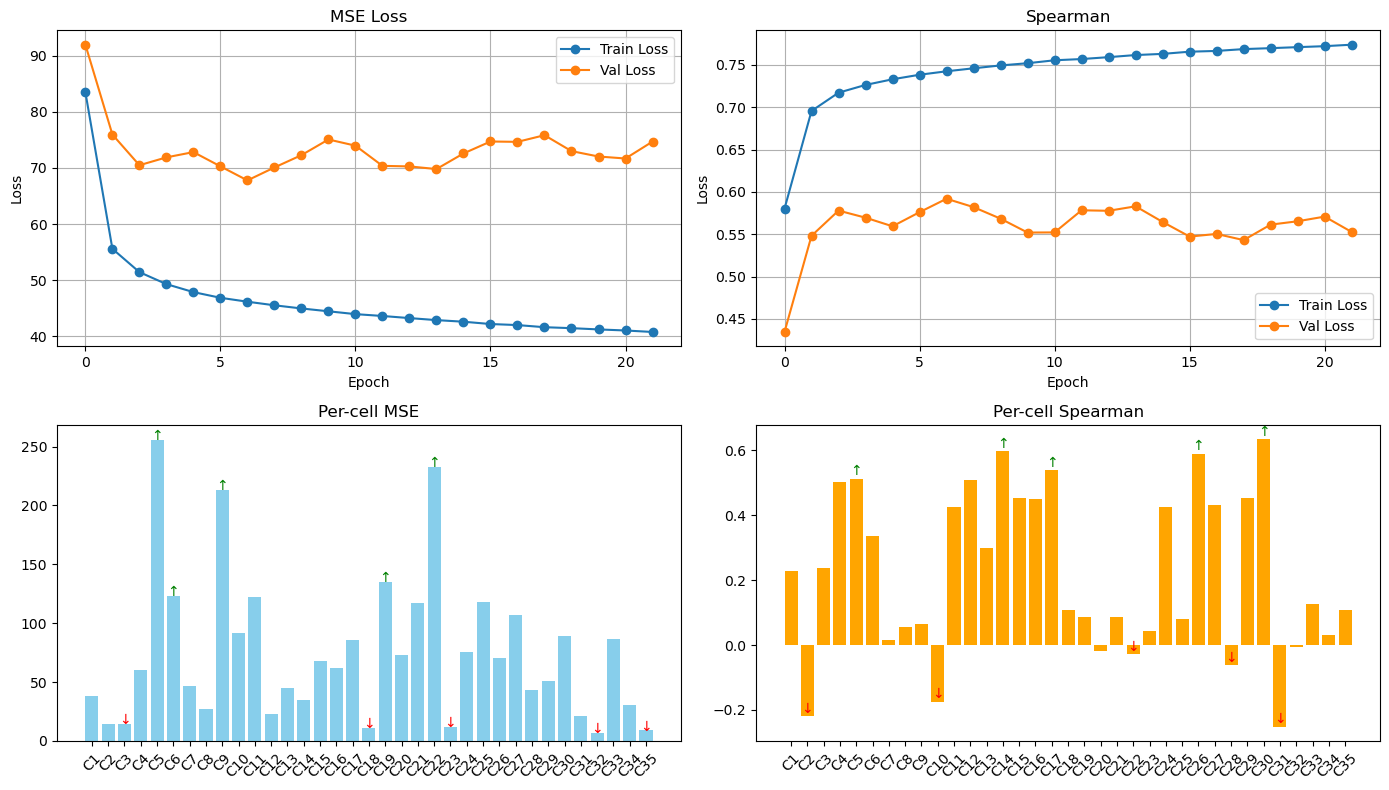

<Figure size 640x480 with 0 Axes>

曲線圖已儲存至 /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/Macenko_masked/fold5/loss_curve.png
⛔ early stop
📈 Fold 5 best ρ = 0.5919

=========== CV summary ===========
fold 0: best ρ = 0.5549
fold 1: best ρ = 0.6172
fold 2: best ρ = 0.5148
fold 3: best ρ = 0.5657
fold 4: best ρ = 0.5196
fold 5: best ρ = 0.5919
overall best (mean) ρ = 0.5607 ± 0.0366


In [41]:
from torch.utils.data import DataLoader
from python_scripts.import_data import importDataset
from python_scripts.aug         import augment_grouped_data, identity, subset_grouped_data
import math
from torch.optim.lr_scheduler import LambdaLR
# ---------------- 基本參數 ----------------
start_fold = 0   # 从第几个 fold 开始训练（0-based），小于此值的 fold 会跳过

BATCH_SIZE   = 64
num_epochs   = 150
repeats      = 5
# ---------------- 參數設定 ----------------
save_root    = save_folder          # 最外層
os.makedirs(save_root, exist_ok=True)

# Seed once at the very top for reproducibility

logo     = LeaveOneGroupOut()
device   = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("✅ device:", device)

overall_best = []
# 在你的脚本文件头部



# ➋ LOGO / GroupKFold 切分索引，對 Dataset 建 Subset
for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(len(slide_idx)), y=None, groups=slide_idx)):
    
        # 如果当前 fold < start_fold，就跳过
    if fold_id < start_fold:
        print(f"⏭️ Skipping fold {fold_id}")
        continue
    
    print("Starting fold", fold_id)
    print("Starting subseting...")

    train_base = subset_grouped_data(grouped_data, tr_idx)
    print("Starting augmenting...")

    train_ds = augment_grouped_data(
                    grouped_data=train_base,
                    image_keys=['tile','subtiles'],
                    repeats=repeats   # 比如对每张做 2 次增强
                )
    print("Starting importDataset...")
    # 1) 原始 dataset
    train_ds = importDataset(train_ds, model,
                            image_keys=['tile','subtiles'],
                            transform=identity)


    # 3) validation raw
    val_ds     = subset_grouped_data(grouped_data, va_idx)
    val_ds     = importDataset(val_ds, model,
                            image_keys=['tile','subtiles'],
                            transform=identity)

    print("Starting DataLoader...")
    # 4) DataLoader 不再動態增強
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=0, pin_memory=False)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=0, pin_memory=False)

    # 5) 一切其餘步驟同之前：定模型、optimizer、train_one_epoch、evaluate……

    print("Starting model...")
    # ----- 新建模型 / 優化器 -----
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="center",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    # 2) monkey‐patch 一个新的 head
    net.decoder  = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
    net = net.to(device)

    # 我们把原来 Adam 换成 AdamW，稍微加一点 weight decay
    peak_lr       = 5e-4
    min_lr        = 1e-6
    warmup_epochs = 0
    total_epochs  = 30

    unfreeze_epoch = 0  # 比如在第 50 个 epoch 解冻 encoder
    encoder_lr     = 1e-5

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, net.parameters()),
        lr=peak_lr, weight_decay=1e-3
    )

    # 定义 lr_lambda
    def lr_lambda(cur_epoch):
        if cur_epoch < warmup_epochs:
            # 线性 warm-up: 从 0 → 1
            return float(cur_epoch + 1) / warmup_epochs
        else:
            # 余弦退火：从 1 → min_lr/peak_lr
            progress = (cur_epoch - warmup_epochs) / (total_epochs - warmup_epochs)
            # cos(0)=1 → cos(pi)=−1, remap to [min_ratio,1]
            min_ratio = min_lr / peak_lr
            return min_ratio + 0.5 * (1 - min_ratio) * (1 + math.cos(math.pi * progress))

    scheduler = LambdaLR(optimizer, lr_lambda)

    stopper = spear_EarlyStopping(patience=20)

    # ----- fold 專屬輸出路徑 -----
    fold_dir  = os.path.join(save_folder, f"fold{fold_id}")
    os.makedirs(fold_dir, exist_ok=True)
    best_model_path = os.path.join(fold_dir, "best_model.pt")
    loss_plot_path  = os.path.join(fold_dir, "loss_curve.png")
    csv_path        = os.path.join(fold_dir, "training_log.csv")

    # ----- CSV log -----
    log_f = open(csv_path, "w", newline="")
    csv_w = csv.writer(log_f)
    csv_w.writerow(["Epoch","TrainLoss","ValLoss","ValSpearman","LR"])

    # ----- 圖形 -----
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    display(fig)

    train_losses = []; val_losses = []
    train_rhos   = []; val_rhos   = []

    best_rho = -1.0
    print("Starting training...")
    for epoch in range(num_epochs):
        if epoch == unfreeze_epoch:
            print(f"*** Unfreezing encoder at epoch {epoch} and adding to optimizer ***")
        # 把 encoder 的参数解冻并加入 optimizer
            net.unfreeze_encoder(lr=encoder_lr, optimizer=optimizer)

        tloss, trho = train_one_epoch(
            net, train_loader, optimizer, device,
            current_epoch=epoch, initial_alpha=0, final_alpha=0, target_epoch=20 )

        vloss, vrho, mse_cell, rho_cell = evaluate(
            net, val_loader, device,
            current_epoch=epoch, initial_alpha=0, final_alpha=0, target_epoch=20 )

        clear_output(wait=True)  # 清除之前的輸出
        axes[0][0].clear()
        axes[0][1].clear()
        axes[1][0].clear()
        axes[1][1].clear()
        # --- save best ---
        if vrho > best_rho:
            best_rho = vrho
            torch.save(net.state_dict(), best_model_path)
            print(f"✅ Saved best model in {best_model_path}!")

        # --- scheduler / early stop ---
        scheduler.step()
        stopper(vrho)


    
        # --- logging ---
        lr = optimizer.param_groups[0]['lr']
        csv_w.writerow([epoch+1, tloss, vloss, vrho, lr])

        train_losses.append(tloss); val_losses.append(vloss)
        train_rhos.append(trho);   val_rhos.append(vrho)
        

        

        # 印出 Epoch 結果
        lr = optimizer.param_groups[0]['lr']
        print(f"[Epoch {epoch+1}]  lr={lr:.2e}, train_loss={tloss:.4f}, val_loss={vloss:.4f}")
        print(f"train spearman: {trho:.4f} | Val spearman: {vrho:.4f} | best: {best_rho:.4f}")
        # --- update plots ---
        plot_losses(train_losses, val_losses, axes[0][0], "MSE Loss")
        plot_losses(train_rhos,   val_rhos,   axes[0][1], "Spearman")
        cell_names = [f"C{i+1}" for i in range(35)]
        plot_per_cell_metrics(mse_cell, rho_cell, cell_names,
                              ax_mse=axes[1][0], ax_spearman=axes[1][1])
        plt.tight_layout(); display(fig); plt.pause(0.1)
        fig.savefig(loss_plot_path)
        print(f"曲線圖已儲存至 {loss_plot_path}")
        if stopper.early_stop:
            print("⛔ early stop"); break

    log_f.close(); plt.close(fig)
    overall_best.append(best_rho) 
    print(f"📈 Fold {fold_id} best ρ = {best_rho:.4f}")

# ========= 整體結果 =========
overall_best = np.array(overall_best)
print("\n=========== CV summary ===========")
for i, r in enumerate(overall_best):
    print(f"fold {i}: best ρ = {r:.4f}")
print(f"overall best (mean) ρ = {overall_best.mean():.4f} ± {overall_best.std():.4f}")

In [8]:
full_dataset = importDataset(grouped_data, model,
                             image_keys=['tile','subtiles'],
                             transform=lambda x: x)

In [ ]:
import os
import numpy as np
import joblib
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from scipy.stats import rankdata
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict
from lightgbm import early_stopping, log_evaluation
import h5py
import pandas as pd
# ---------------- Settings ----------------
save_root  = save_folder  # your save_folder path
n_folds    = len([d for d in os.listdir(save_root) if d.startswith('fold')])
n_samples  = len(full_dataset)
C          = 35  # num cell types
start_fold = 0
BATCH_SIZE = 64
# If optimizing Spearman, convert labels to ranks

# --- 1) Prepare OOF meta-features ---
# Initialize matrix for OOF predictions
n_samples = len(full_dataset)
oof_preds = np.zeros((n_samples, C), dtype=np.float32)
# True labels (raw or rank)
# importDataset returns a dict-like sample, so label is under key 'label'
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy() for i in range(n_samples) ])
y_meta = y_true

# Build CV splitter (must match first stage splits)
logo = LeaveOneGroupOut()
image_latents = np.zeros((n_samples, 128), dtype=np.float32)

# Loop over folds, load best model, predict on validation indices
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(n_samples), y=None, groups=slide_idx)):
    # Load model
    # if fold_id > start_fold:
    #     print(f"⏭️ Skipping fold {fold_id}")
    #     continue
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    print(f"Loading model from {ckpt_path}...")
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    # 2) monkey‐patch 一个新的 head
    net.decoder  = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
    net = net.to(device)    # Alternatively, if your model requires specific args, replace with:
    # net = VisionMLP_MultiTask(tile_dim=64, subtile_dim=64, output_dim=35).to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.to(device).eval()
    
    # Predict on validation set
    val_ds = Subset(full_dataset, va_idx)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    preds = []
    latents = []

    with torch.no_grad():
        for batch in val_loader:
            tiles    = batch['tile'].to(device)
            subtiles = batch['subtiles'].to(device)

            center = subtiles[:, 4].contiguous()
            f_c = net.enc_center(center)
            f_n = net.enc_neigh(subtiles)
            fuse = torch.cat([f_c, f_n], dim=1)

            output = net.decoder(fuse)

            preds.append(output.cpu())
            latents.append(fuse.cpu())  # ⬅️ 收集 latent vector

    preds = torch.cat(preds, dim=0).numpy()    # (n_val, 35)
    latents = torch.cat(latents, dim=0).numpy()  # (n_val, 128)

    oof_preds[va_idx] = preds
    image_latents[va_idx] = latents

    print(f"Fold {fold_id}: OOF preds shape {preds.shape}, Latent shape: {latents.shape}")


    
with h5py.File("dataset/realign/filtered_dataset.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        spot_array = np.array(train_spots[slide_name])
        df = pd.DataFrame(spot_array)
        df["slide_name"] = slide_name
        train_spot_tables[slide_name] = df
        print(f"✅ 已讀取 slide: {slide_name}")

# -----------------------------------------------------
# Step 2: 合併所有 slide 的資料
# -----------------------------------------------------
all_train_spots_df = pd.concat(train_spot_tables.values(), ignore_index=True)
# 提取 x, y
xy = all_train_spots_df[["x", "y"]].to_numpy()  # shape: (8348, 2)

# 合併成新的 meta feature
meta_features = np.concatenate([oof_preds, xy, image_latents], axis=1)
# --- 2) Train LightGBM meta-model ---
# Choose objective: regression on rank (for Spearman) or raw (for MSE)
# 將 meta features 拆成訓練集與 early stopping 用的驗證集
X_train, X_val, y_train, y_val = train_test_split(meta_features, y_meta, test_size=0.2, random_state=42)
print("Meta feature shape:", X_train.shape)
print("Feature std (min/max):", np.min(np.std(X_train, axis=0)), np.max(np.std(X_train, axis=0)))


# # Base model
# lgb_base = lgb.LGBMRegressor(
#     objective='l2',
#     metric='rmse',
#     n_estimators=12000,
#     max_depth=15,
#     learning_rate=0.008,
#     num_leaves=32,
#     colsample_bytree=0.25
# )

lgb_base = lgb.LGBMRegressor(
    objective='l2',
    metric='rmse',
    learning_rate=0.007522970004049377,
    n_estimators=12000,
    max_depth=11,
    num_leaves=194,
    colsample_bytree=0.7619407413363416,
    subsample=0.8,
    subsample_freq=1,
    min_data_in_leaf=20,
    reg_alpha=0.7480401395491829,
    reg_lambda=0.2589860348178542,
    verbosity=-1
)
# 將每個 target 分別 early stopping
meta_model = MultiOutputRegressor(lgb_base)

print("Training LightGBM on OOF meta-features with early stopping...")
meta_model.estimators_ = []

for i in range(y_train.shape[1]):
    print(f"Training target {i}...")
    model  = lgb.LGBMRegressor(
        objective='l2',
        metric='rmse',
        learning_rate=0.007522970004049377,
        n_estimators=12000,
        max_depth=11,
        num_leaves=194,
        colsample_bytree=0.7619407413363416,
        subsample=0.8,
        subsample_freq=1,
        min_data_in_leaf=20,
        reg_alpha=0.7480401395491829,
        reg_lambda=0.2589860348178542,
        verbosity=-1
    )

    model.fit(
        X_train,
        y_train[:, i],
        eval_set=[(X_val, y_val[:, i])],
        callbacks=[
            early_stopping(stopping_rounds=200),
            log_evaluation(period=100)
        ]
    )

    meta_model.estimators_.append(model)

# 保存模型
joblib.dump(meta_model, os.path.join(save_root, 'meta_model.pkl'))


# --- 3) Prepare test meta-features ---
n_test = len(test_dataset)
test_preds = []
test_latents = []

for fold_id in range(n_folds):
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    net.decoder = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
    )

    net = net.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds = []
    latents = []

    with torch.no_grad():
        for batch in test_loader:
            tiles = batch['tile'].to(device)
            subtiles = batch['subtiles'].to(device)

            center = subtiles[:, 4].contiguous()
            f_c = net.enc_center(center)
            f_n = net.enc_neigh(subtiles)
            fuse = torch.cat([f_c, f_n], dim=1)

            out = net.decoder(fuse)

            preds.append(out.cpu())
            latents.append(fuse.cpu())  # image embedding (128D)

    test_preds.append(torch.cat(preds, dim=0).numpy())      # shape: (n_test, 35)
    test_latents.append(torch.cat(latents, dim=0).numpy())  # shape: (n_test, 128)

# === Stack + Average ===
test_preds = np.mean(np.stack(test_preds, axis=0), axis=0)      # (n_test, 35)
test_latents = np.mean(np.stack(test_latents, axis=0), axis=0)  # (n_test, 128)

with h5py.File("dataset/elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    spot_array = np.array(test_spots['S_7'])
    df = pd.DataFrame(spot_array)

xy = df[["x", "y"]].to_numpy()  # shape: (n_test, 2)

# 合併為最終 test meta features
test_meta = np.concatenate([test_preds, xy, test_latents], axis=1)  # shape: (n_test, 35+2+128)



final_preds = meta_model.predict(test_meta)

# --- Save submission ---
import h5py
import pandas as pd
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))
sub = pd.DataFrame(final_preds, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(save_root, 'submission_stacked.csv'), index=False)
print("✅ Saved stacked submission.")


Loading model from /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/Macenko_masked/fold0/best_model.pt...


/Users/deweywang/Desktop/GitHub/HEVisum/python_scripts/pretrain_model.py:228: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae.load_state_dict(torch.load(ae_checkpoint, map_

Fold 0: OOF preds shape (2197, 35), Latent shape: (2197, 128)
Loading model from /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/Macenko_masked/fold1/best_model.pt...
Fold 1: OOF preds shape (2269, 35), Latent shape: (2269, 128)
Loading model from /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/Macenko_masked/fold2/best_model.pt...
Fold 2: OOF preds shape (690, 35), Latent shape: (690, 128)
Loading model from /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/Macenko_masked/fold3/best_model.pt...
Fold 3: OOF preds shape (1187, 35), Latent shape: (1187, 128)
Loading model from /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/Macenko_

/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 5.80501
[200]	valid_0's rmse: 5.16732
[300]	valid_0's rmse: 4.98894
[400]	valid_0's rmse: 4.93901
[500]	valid_0's rmse: 4.92389
[600]	valid_0's rmse: 4.91418
[700]	valid_0's rmse: 4.91208
[800]	valid_0's rmse: 4.91066
[900]	valid_0's rmse: 4.90974
[1000]	valid_0's rmse: 4.91035
[1100]	valid_0's rmse: 4.91088
Early stopping, best iteration is:
[922]	valid_0's rmse: 4.90915
Training target 1...


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.69449
[200]	valid_0's rmse: 2.37986
[300]	valid_0's rmse: 2.2612
[400]	valid_0's rmse: 2.21058
[500]	valid_0's rmse: 2.18918
[600]	valid_0's rmse: 2.18068
[700]	valid_0's rmse: 2.17519
[800]	valid_0's rmse: 2.17074
[900]	valid_0's rmse: 2.17025
[1000]	valid_0's rmse: 2.16935
[1100]	valid_0's rmse: 2.16771
[1200]	valid_0's rmse: 2.16647
[1300]	valid_0's rmse: 2.16597
[1400]	valid_0's rmse: 2.16576
[1500]	valid_0's rmse: 2.16583
[1600]	valid_0's rmse: 2.1665
Early stopping, best iteration is:
[1460]	valid_0's rmse: 2.1653
Training target 2...


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 4.11374
[200]	valid_0's rmse: 3.5442
[300]	valid_0's rmse: 3.38255
[400]	valid_0's rmse: 3.32953
[500]	valid_0's rmse: 3.31459
[600]	valid_0's rmse: 3.30726
[700]	valid_0's rmse: 3.29961
[800]	valid_0's rmse: 3.29828
[900]	valid_0's rmse: 3.29873
[1000]	valid_0's rmse: 3.29903
[1100]	valid_0's rmse: 3.29893
Early stopping, best iteration is:
[923]	valid_0's rmse: 3.29799
Training target 3...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 8.23217
[200]	valid_0's rmse: 7.00764
[300]	valid_0's rmse: 6.65733
[400]	valid_0's rmse: 6.56349
[500]	valid_0's rmse: 6.52981
[600]	valid_0's rmse: 6.50831
[700]	valid_0's rmse: 6.50079
[800]	valid_0's rmse: 6.4973
[900]	valid_0's rmse: 6.49422
[1000]	valid_0's rmse: 6.49336
[1100]	valid_0's rmse: 6.49239
[1200]	valid_0's rmse: 6.49443
Early stopping, best iteration is:
[1085]	valid_0's rmse: 6.49217
Training target 4...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.59718
[200]	valid_0's rmse: 6.42311
[300]	valid_0's rmse: 5.99202
[400]	valid_0's rmse: 5.83578
[500]	valid_0's rmse: 5.77651
[600]	valid_0's rmse: 5.74737
[700]	valid_0's rmse: 5.73341
[800]	valid_0's rmse: 5.72514
[900]	valid_0's rmse: 5.71787
[1000]	valid_0's rmse: 5.71312
[1100]	valid_0's rmse: 5.7087
[1200]	valid_0's rmse: 5.70323
[1300]	valid_0's rmse: 5.69974
[1400]	valid_0's rmse: 5.69668
[1500]	valid_0's rmse: 5.69682
[1600]	valid_0's rmse: 5.69647
Early stopping, best iteration is:
[1419]	valid_0's rmse: 5.69573
Training target 5...


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 7.96888
[200]	valid_0's rmse: 6.80035
[300]	valid_0's rmse: 6.39354
[400]	valid_0's rmse: 6.24312
[500]	valid_0's rmse: 6.18496
[600]	valid_0's rmse: 6.16678
[700]	valid_0's rmse: 6.15894
[800]	valid_0's rmse: 6.15411
[900]	valid_0's rmse: 6.14871
[1000]	valid_0's rmse: 6.14578
[1100]	valid_0's rmse: 6.14365
[1200]	valid_0's rmse: 6.14277
[1300]	valid_0's rmse: 6.14126
[1400]	valid_0's rmse: 6.14062
[1500]	valid_0's rmse: 6.13959
[1600]	valid_0's rmse: 6.13969
[1700]	valid_0's rmse: 6.13793
[1800]	valid_0's rmse: 6.13745
[1900]	valid_0's rmse: 6.1358
[2000]	valid_0's rmse: 6.13472
[2100]	valid_0's rmse: 6.13459
[2200]	valid_0's rmse: 6.13384
[2300]	valid_0's rmse: 6.13303
[2400]	valid_0's rmse: 6.13313
[2500]	valid_0's rmse: 6.13315
Early stopping, best iteration is:
[2331]	valid_0's rmse: 6.13239
Training target 6...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 3.80067
[200]	valid_0's rmse: 3.54318
[300]	valid_0's rmse: 3.43924
[400]	valid_0's rmse: 3.39787
[500]	valid_0's rmse: 3.37914
[600]	valid_0's rmse: 3.37004
[700]	valid_0's rmse: 3.36538
[800]	valid_0's rmse: 3.36448
[900]	valid_0's rmse: 3.36591
[1000]	valid_0's rmse: 3.36503
Early stopping, best iteration is:
[816]	valid_0's rmse: 3.36373
Training target 7...


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 5.60211
[200]	valid_0's rmse: 5.50209
[300]	valid_0's rmse: 5.48028
[400]	valid_0's rmse: 5.48064
Early stopping, best iteration is:
[280]	valid_0's rmse: 5.47849
Training target 8...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 8.6219
[200]	valid_0's rmse: 7.3081
[300]	valid_0's rmse: 6.81269
[400]	valid_0's rmse: 6.63061
[500]	valid_0's rmse: 6.55721
[600]	valid_0's rmse: 6.52375
[700]	valid_0's rmse: 6.5142
[800]	valid_0's rmse: 6.50918
[900]	valid_0's rmse: 6.50393
[1000]	valid_0's rmse: 6.49945
[1100]	valid_0's rmse: 6.49541
[1200]	valid_0's rmse: 6.49285
[1300]	valid_0's rmse: 6.49022
[1400]	valid_0's rmse: 6.48782
[1500]	valid_0's rmse: 6.48795
[1600]	valid_0's rmse: 6.48632
[1700]	valid_0's rmse: 6.48601
[1800]	valid_0's rmse: 6.48475
[1900]	valid_0's rmse: 6.48479
[2000]	valid_0's rmse: 6.48437
[2100]	valid_0's rmse: 6.48434
[2200]	valid_0's rmse: 6.48401
[2300]	valid_0's rmse: 6.48428
[2400]	valid_0's rmse: 6.48413
[2500]	valid_0's rmse: 6.48242
[2600]	valid_0's rmse: 6.48086
[2700]	valid_0's rmse: 6.4809
[2800]	valid_0's rmse: 6.48039
[2900]	valid_0's rmse: 6.47982
[3000]	valid_0's rmse: 6.4801
[3100]	valid_0's rmse: 6.47977
[3200]	valid_0's rmse: 6.47959
[3300]	valid_0's rmse:

/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.06993
[200]	valid_0's rmse: 5.95931
[300]	valid_0's rmse: 5.62163
[400]	valid_0's rmse: 5.49885
[500]	valid_0's rmse: 5.44963
[600]	valid_0's rmse: 5.41849
[700]	valid_0's rmse: 5.40725
[800]	valid_0's rmse: 5.39948
[900]	valid_0's rmse: 5.39222
[1000]	valid_0's rmse: 5.38818
[1100]	valid_0's rmse: 5.38752
[1200]	valid_0's rmse: 5.38456
[1300]	valid_0's rmse: 5.38396
[1400]	valid_0's rmse: 5.38411
[1500]	valid_0's rmse: 5.38376
[1600]	valid_0's rmse: 5.38314
[1700]	valid_0's rmse: 5.38322
[1800]	valid_0's rmse: 5.38231
[1900]	valid_0's rmse: 5.38106
[2000]	valid_0's rmse: 5.38167
Early stopping, best iteration is:
[1894]	valid_0's rmse: 5.38091
Training target 10...


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 7.61319
[200]	valid_0's rmse: 6.7932
[300]	valid_0's rmse: 6.52082
[400]	valid_0's rmse: 6.41832
[500]	valid_0's rmse: 6.37312
[600]	valid_0's rmse: 6.35016
[700]	valid_0's rmse: 6.33457
[800]	valid_0's rmse: 6.32756
[900]	valid_0's rmse: 6.31902
[1000]	valid_0's rmse: 6.3079
[1100]	valid_0's rmse: 6.30259
[1200]	valid_0's rmse: 6.29951
[1300]	valid_0's rmse: 6.29782
[1400]	valid_0's rmse: 6.29399
[1500]	valid_0's rmse: 6.29144
[1600]	valid_0's rmse: 6.28877
[1700]	valid_0's rmse: 6.28782
[1800]	valid_0's rmse: 6.28508
[1900]	valid_0's rmse: 6.28413
[2000]	valid_0's rmse: 6.28473
Early stopping, best iteration is:
[1853]	valid_0's rmse: 6.28361
Training target 11...


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 4.39907
[200]	valid_0's rmse: 3.77049
[300]	valid_0's rmse: 3.55373
[400]	valid_0's rmse: 3.46932
[500]	valid_0's rmse: 3.43411
[600]	valid_0's rmse: 3.41981
[700]	valid_0's rmse: 3.41258
[800]	valid_0's rmse: 3.41001
[900]	valid_0's rmse: 3.40754
[1000]	valid_0's rmse: 3.40618
[1100]	valid_0's rmse: 3.40527
[1200]	valid_0's rmse: 3.40527
[1300]	valid_0's rmse: 3.40612
Early stopping, best iteration is:
[1156]	valid_0's rmse: 3.40477
Training target 12...


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 6.12857
[200]	valid_0's rmse: 6.07173
[300]	valid_0's rmse: 6.06024
[400]	valid_0's rmse: 6.06255
Early stopping, best iteration is:
[295]	valid_0's rmse: 6.05931
Training target 13...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 5.47805
[200]	valid_0's rmse: 5.1962
[300]	valid_0's rmse: 5.13593
[400]	valid_0's rmse: 5.11934
[500]	valid_0's rmse: 5.11671
[600]	valid_0's rmse: 5.12197
Early stopping, best iteration is:
[449]	valid_0's rmse: 5.11565
Training target 14...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 6.30828
[200]	valid_0's rmse: 5.34809
[300]	valid_0's rmse: 5.03921
[400]	valid_0's rmse: 4.92629
[500]	valid_0's rmse: 4.88762
[600]	valid_0's rmse: 4.87227
[700]	valid_0's rmse: 4.86538
[800]	valid_0's rmse: 4.85978
[900]	valid_0's rmse: 4.85549
[1000]	valid_0's rmse: 4.85248
[1100]	valid_0's rmse: 4.85245
[1200]	valid_0's rmse: 4.85212
Early stopping, best iteration is:
[1042]	valid_0's rmse: 4.85123
Training target 15...


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 6.07983
[200]	valid_0's rmse: 5.41568
[300]	valid_0's rmse: 5.21777
[400]	valid_0's rmse: 5.13657
[500]	valid_0's rmse: 5.10843
[600]	valid_0's rmse: 5.09696
[700]	valid_0's rmse: 5.09459
[800]	valid_0's rmse: 5.09207
[900]	valid_0's rmse: 5.08845
[1000]	valid_0's rmse: 5.08278
[1100]	valid_0's rmse: 5.08159
[1200]	valid_0's rmse: 5.07979
[1300]	valid_0's rmse: 5.07919
[1400]	valid_0's rmse: 5.0796
[1500]	valid_0's rmse: 5.07946
Early stopping, best iteration is:
[1333]	valid_0's rmse: 5.07837
Training target 16...


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 7.37947
[200]	valid_0's rmse: 6.40509
[300]	valid_0's rmse: 6.06909
[400]	valid_0's rmse: 5.94837
[500]	valid_0's rmse: 5.89707
[600]	valid_0's rmse: 5.87166
[700]	valid_0's rmse: 5.85552
[800]	valid_0's rmse: 5.84525
[900]	valid_0's rmse: 5.84008
[1000]	valid_0's rmse: 5.83232
[1100]	valid_0's rmse: 5.82377
[1200]	valid_0's rmse: 5.8228
[1300]	valid_0's rmse: 5.81915
[1400]	valid_0's rmse: 5.81557
[1500]	valid_0's rmse: 5.8132
[1600]	valid_0's rmse: 5.81223
[1700]	valid_0's rmse: 5.80963
[1800]	valid_0's rmse: 5.80829
[1900]	valid_0's rmse: 5.80753
[2000]	valid_0's rmse: 5.80634
[2100]	valid_0's rmse: 5.805
[2200]	valid_0's rmse: 5.80499
[2300]	valid_0's rmse: 5.80403
[2400]	valid_0's rmse: 5.80266
[2500]	valid_0's rmse: 5.8023
[2600]	valid_0's rmse: 5.80165
[2700]	valid_0's rmse: 5.80073
[2800]	valid_0's rmse: 5.79981
[2900]	valid_0's rmse: 5.79943
[3000]	valid_0's rmse: 5.79931
[3100]	valid_0's rmse:

In [ ]:
import os
import numpy as np
import joblib
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from scipy.stats import rankdata
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict
from lightgbm import early_stopping, log_evaluation
import h5py
import pandas as pd
# ---------------- Settings ----------------
save_root  = save_folder  # your save_folder path
n_folds    = len([d for d in os.listdir(save_root) if d.startswith('fold')])
n_samples  = len(full_dataset)
C          = 35  # num cell types
start_fold = 0
BATCH_SIZE = 64
# If optimizing Spearman, convert labels to ranks

# --- 1) Prepare OOF meta-features ---
# Initialize matrix for OOF predictions
n_samples = len(full_dataset)
oof_preds = np.zeros((n_samples, C), dtype=np.float32)
# True labels (raw or rank)
# importDataset returns a dict-like sample, so label is under key 'label'
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy() for i in range(n_samples) ])
y_meta = y_true

# Build CV splitter (must match first stage splits)
logo = LeaveOneGroupOut()
image_latents = np.zeros((n_samples, 128), dtype=np.float32)

# Loop over folds, load best model, predict on validation indices
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(n_samples), y=None, groups=slide_idx)):
    # Load model
    # if fold_id > start_fold:
    #     print(f"⏭️ Skipping fold {fold_id}")
    #     continue
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    print(f"Loading model from {ckpt_path}...")
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    # 2) monkey‐patch 一个新的 head
    net.decoder  = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
    net = net.to(device)    # Alternatively, if your model requires specific args, replace with:
    # net = VisionMLP_MultiTask(tile_dim=64, subtile_dim=64, output_dim=35).to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.to(device).eval()
    
    # Predict on validation set
    val_ds = Subset(full_dataset, va_idx)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    preds = []
    latents = []

    with torch.no_grad():
        for batch in val_loader:
            tiles    = batch['tile'].to(device)
            subtiles = batch['subtiles'].to(device)

            center = subtiles[:, 4].contiguous()
            f_c = net.enc_center(center)
            f_n = net.enc_neigh(subtiles)
            fuse = torch.cat([f_c, f_n], dim=1)

            output = net.decoder(fuse)

            preds.append(output.cpu())
            latents.append(fuse.cpu())  # ⬅️ 收集 latent vector

    preds = torch.cat(preds, dim=0).numpy()    # (n_val, 35)
    latents = torch.cat(latents, dim=0).numpy()  # (n_val, 128)

    oof_preds[va_idx] = preds
    image_latents[va_idx] = latents

    print(f"Fold {fold_id}: OOF preds shape {preds.shape}, Latent shape: {latents.shape}")


    
with h5py.File("dataset/realign/filtered_dataset.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        spot_array = np.array(train_spots[slide_name])
        df = pd.DataFrame(spot_array)
        df["slide_name"] = slide_name
        train_spot_tables[slide_name] = df
        print(f"✅ 已讀取 slide: {slide_name}")

# -----------------------------------------------------
# Step 2: 合併所有 slide 的資料
# -----------------------------------------------------
all_train_spots_df = pd.concat(train_spot_tables.values(), ignore_index=True)
# 提取 x, y
xy = all_train_spots_df[["x", "y"]].to_numpy()  # shape: (8348, 2)

# 合併成新的 meta feature
meta_features = np.concatenate([oof_preds, xy, image_latents], axis=1)
# --- 2) Train LightGBM meta-model ---
# Choose objective: regression on rank (for Spearman) or raw (for MSE)
# 將 meta features 拆成訓練集與 early stopping 用的驗證集
X_train, X_val, y_train, y_val = train_test_split(meta_features, y_meta, test_size=0.2, random_state=42)
print("Meta feature shape:", X_train.shape)
print("Feature std (min/max):", np.min(np.std(X_train, axis=0)), np.max(np.std(X_train, axis=0)))


# # Base model
# lgb_base = lgb.LGBMRegressor(
#     objective='l2',
#     metric='rmse',
#     n_estimators=12000,
#     max_depth=15,
#     learning_rate=0.008,
#     num_leaves=32,
#     colsample_bytree=0.25
# )
import optuna
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

# Define Optuna objective function
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'device': 'gpu',                # ✅ GPU 支援
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'learning_rate': trial.suggest_float("learning_rate", 0.005, 0.1),
        'max_depth': trial.suggest_int("max_depth", 4, 15),
        'num_leaves': trial.suggest_int("num_leaves", 32, 256),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 20, 100),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.6, 1.0),
        'reg_alpha': trial.suggest_float("reg_alpha", 0, 1),
        'reg_lambda': trial.suggest_float("reg_lambda", 0, 1),
        'n_estimators': 12000
    }

    model = lgb.LGBMRegressor(**params)
    multi_model = MultiOutputRegressor(model)
    multi_model.fit(X_train, y_train)

    y_pred = multi_model.predict(X_val)
    rmse = np.mean([
        np.sqrt(mean_squared_error(y_val[:, i], y_pred[:, i]))
        for i in range(y_val.shape[1])
    ])


    return rmse

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Use best params to train final models
best_params = study.best_trial.params
best_params['objective'] = 'l2'
best_params['metric'] = 'rmse'
best_params['verbosity'] = -1

# Train final models with best parameters
meta_model = MultiOutputRegressor(lgb.LGBMRegressor(**best_params))
meta_model.estimators_ = []

print("Training LightGBM on OOF meta-features with best Optuna params...")
for i in range(y_train.shape[1]):
    print(f"Training target {i}...")
    model = lgb.LGBMRegressor(**best_params)

    model.fit(
        X_train,
        y_train[:, i],
        eval_set=[(X_val, y_val[:, i])],
        callbacks=[
            early_stopping(stopping_rounds=200),
            log_evaluation(period=100)
        ]
    )

    meta_model.estimators_.append(model)

# Save model
joblib.dump(meta_model, os.path.join(save_root, 'meta_model.pkl'))
# 保存模型


# --- 3) Prepare test meta-features ---
n_test = len(test_dataset)
test_preds = []
test_latents = []

for fold_id in range(n_folds):
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    net.decoder = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
    )

    net = net.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds = []
    latents = []

    with torch.no_grad():
        for batch in test_loader:
            tiles = batch['tile'].to(device)
            subtiles = batch['subtiles'].to(device)

            center = subtiles[:, 4].contiguous()
            f_c = net.enc_center(center)
            f_n = net.enc_neigh(subtiles)
            fuse = torch.cat([f_c, f_n], dim=1)

            out = net.decoder(fuse)

            preds.append(out.cpu())
            latents.append(fuse.cpu())  # image embedding (128D)

    test_preds.append(torch.cat(preds, dim=0).numpy())      # shape: (n_test, 35)
    test_latents.append(torch.cat(latents, dim=0).numpy())  # shape: (n_test, 128)

# === Stack + Average ===
test_preds = np.mean(np.stack(test_preds, axis=0), axis=0)      # (n_test, 35)
test_latents = np.mean(np.stack(test_latents, axis=0), axis=0)  # (n_test, 128)

with h5py.File("dataset/elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    spot_array = np.array(test_spots['S_7'])
    df = pd.DataFrame(spot_array)

xy = df[["x", "y"]].to_numpy()  # shape: (n_test, 2)

# 合併為最終 test meta features
test_meta = np.concatenate([test_preds, xy, test_latents], axis=1)  # shape: (n_test, 35+2+128)



final_preds = meta_model.predict(test_meta)

# --- Save submission ---
import h5py
import pandas as pd
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))
sub = pd.DataFrame(final_preds, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(save_root, 'submission_stacked.csv'), index=False)
print("✅ Saved stacked submission.")


Loading model from /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/Macenko_masked/fold0/best_model.pt...


/Users/deweywang/Desktop/GitHub/HEVisum/python_scripts/pretrain_model.py:228: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae.load_state_dict(torch.load(ae_checkpoint, map_

Fold 0: OOF preds shape (2197, 35), Latent shape: (2197, 128)
Loading model from /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/Macenko_masked/fold1/best_model.pt...
Fold 1: OOF preds shape (2269, 35), Latent shape: (2269, 128)
Loading model from /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/Macenko_masked/fold2/best_model.pt...
Fold 2: OOF preds shape (690, 35), Latent shape: (690, 128)
Loading model from /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/Macenko_masked/fold3/best_model.pt...
Fold 3: OOF preds shape (1187, 35), Latent shape: (1187, 128)
Loading model from /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/Macenko_

[I 2025-05-05 11:11:50,825] A new study created in memory with name: no-name-52464a7a-6478-452d-a0de-2374dc3a79f0


Meta feature shape: (6678, 165)
Feature std (min/max): 0.014387979319250175 352.8783576435113


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

In [ ]:
import os
import numpy as np
import joblib
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from scipy.stats import rankdata
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict

# --- 配置: 只用哪些 fold 的结果来训练/预测 meta-model ---
meta_folds = [0]  # 例如只用 fold0, fold2, fold4

# 1) 准备 full_dataset, slide_idx, test_dataset 等
full_dataset = importDataset(
    grouped_data, model,
    image_keys=['tile','subtiles'],
    transform=lambda x: x
)
n_samples = len(full_dataset)
C = 35  # 类别数

# 2) 预留 oof_preds 和 fold_ids
oof_preds    = np.zeros((n_samples, C), dtype=np.float32)
oof_fold_ids = np.full(n_samples, -1, dtype=int)

# 真标签
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy() for i in range(n_samples) ])
y_meta = y_true.copy()  # 不做 rank 时直接用 raw

# 3) 生成 OOF 预测并记录 fold id
logo = LeaveOneGroupOut()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(n_samples), y=None, groups=slide_idx)):

    # 如果当前 fold 不在我们想要的 meta_folds 列表里，就跳过
    if fold_id not in meta_folds:
        print(f"⏭️ Skipping OOF for fold {fold_id}")
        continue

    print(f"\n>>> Generating OOF for fold {fold_id}")
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    # 2) monkey‐patch 一个新的 head
    net.decoder  = nn.Sequential(
        nn.Linear(64+64, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
    net = net.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    val_loader = DataLoader(Subset(full_dataset, va_idx), batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, val_loader, device)  # (n_val, C)

    oof_preds[va_idx]    = preds
    oof_fold_ids[va_idx] = fold_id

    print(f"  → Fold {fold_id} OOF preds shape: {preds.shape}")
# 4) 只选取 meta_folds 的行来训练 meta-model
mask = np.isin(oof_fold_ids, meta_folds)
X_meta = oof_preds[mask]
y_meta_sub = y_meta[mask]

print(f"\nTraining meta-model on folds {meta_folds}:")
print(f"  使用样本数：{X_meta.shape[0]} / {n_samples}")

lgb_base = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.001,
    n_estimators=1000,
    num_leaves=31,
    subsample=0.7,
    colsample_bytree=0.7,
    n_jobs=-1,
    force_col_wise=True
)
meta_model = MultiOutputRegressor(lgb_base)
meta_model.fit(X_meta, y_meta_sub)
joblib.dump(meta_model, os.path.join(save_root, 'meta_model.pkl'))

# 5) 准备 test_meta，只平均 meta_folds 中的预测
n_folds = len([d for d in os.listdir(save_root) if d.startswith('fold')])
n_test  = len(test_dataset)
test_meta = np.zeros((n_test, C), dtype=np.float32)

for fold_id in range(n_folds):
    if fold_id not in meta_folds:
        continue
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    # 2) monkey‐patch 一个新的 head
    net.decoder  = nn.Sequential(
        nn.Linear(64+64, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
    net = net.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, loader, device)
    test_meta += preds

# 平均时除以参与的 folds 数目
test_meta /= len(meta_folds)

# 6) 用 meta-model 做最终预测
final_preds = meta_model.predict(test_meta)

# --- Save submission ---
import h5py
import pandas as pd

with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))

sub = pd.DataFrame(final_preds, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(save_root, 'submission_stacked.csv'), index=False)
print("✅ Saved stacked submission.")


NameError: name 'slide_idx' is not defined

# Predict

In [12]:
import torch
import inspect
from python_scripts.operate_model import get_model_inputs

def load_node_feature_data(pt_path: str, model, num_cells: int = 35) -> dict:
    """
    根据 model.forward 的参数自动加载 .pt 里对应的字段，
    并且如果没有 label，就自动创建一个全 0 的 label 张量，
    其尺寸为 (样本数, num_cells)，样本数从第一个有 __len__ 的输入推断。

    参数：
      pt_path:     str，.pt 文件路径
      model:       已实例化的 PyTorch 模型
      num_cells:   int，label 的列数（默认 35）

    返回：
      dict: key 对应模型 forward 中的参数名（不含 self），
            value 是对应的 Tensor/ndarray，
            并额外保证有 'label' 字段。
    """
    # 1) 载入原始数据
    raw = torch.load(pt_path, map_location="cpu")

    # 2) 取模型 forward 入参签名（不含 self）
    sig = inspect.signature(model.forward)
    param_names = [p for p in sig.parameters if p != "self"]

    out = {}
    for name in param_names:
        # a) 直接同名
        if name in raw:
            out[name] = raw[name]
            continue
        # b) 复数形式
        if name + "s" in raw:
            out[name] = raw[name + "s"]
            continue
        # c) 模糊匹配（下划线、复数或前后缀）
        cands = [k for k in raw if name in k or k in name]
        if len(cands) == 1:
            out[name] = raw[cands[0]]
            continue
        raise KeyError(f"无法找到 '{name}' 在 pt 文件中的对应字段，raw keys: {list(raw.keys())}")

    # 3) 用第一个支持 len() 的输入推断样本数
    dataset_size = None
    for v in out.keys():
        if hasattr(out[v], "__len__"):
            dataset_size = len(out[v])
            print(f"⚠️ 从 '{v}' 推断样本数量: {dataset_size}")
            break
    if dataset_size is None:
        raise RuntimeError("无法从任何输入中推断样本数量，请检查 pt 文件内容。")

    # 4) 自动补 label

    out["label"] = torch.zeros((dataset_size, num_cells), dtype=torch.float32)
    return out


image_keys = [ 'tile', 'subtiles']


# 用法示例
from python_scripts.import_data import importDataset
# 假设你的 model 已经定义好并实例化为 `model`
test_dataset = load_node_feature_data("dataset/spot-rank/filtered_directly_rank/masked/test/Macenko/test_dataset.pt", model)
test_dataset = importDataset(
        data_dict=test_dataset,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )



/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_1156/2163754159.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(pt_path, map_location="cpu")

⚠️ 从 'tile' 推断样本数量: 2088
Model forward signature: (tile, subtiles)


In [11]:

test_dataset.check_item(1000, 10)


🔍 Checking dataset sample: 1000
📏 tile shape: torch.Size([3, 78, 78]) | dtype: torch.float32 | min: 0.200, max: 1.000, mean: 0.729, std: 0.152
📏 subtiles shape: torch.Size([9, 3, 26, 26]) | dtype: torch.float32 | min: 0.200, max: 1.000, mean: 0.729, std: 0.152
📏 label shape: torch.Size([35]) | dtype: torch.float32 | min: 0.000, max: 0.000, mean: 0.000, std: 0.000
--- label head (前 10 個元素):
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
✅ All checks passed!


In [13]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [45]:
import glob
import torch
import numpy as np
import pandas as pd
import os
import h5py
from torch.utils.data import DataLoader

# 讀 test spot index
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spots     = f["spots/Test"]
    test_spot_table= pd.DataFrame(np.array(test_spots['S_7']))

fold_ckpts = sorted(glob.glob(os.path.join(save_folder, "fold*", "best_model.pt")))
models = []
for ckpt in fold_ckpts:
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = False
    )

    # 2) monkey‐patch 一个新的 head
    net.decoder  = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
    net = net.to(device)
    net.load_state_dict(torch.load(ckpt, map_location="cpu"))
    net.to(device).eval()
    models.append(net)

all_fold_preds = []
for fold_id, net in enumerate(models):
    # 推論
    with torch.no_grad():
        preds = predict(net, test_loader, device)  # (N_test,35) numpy array

    # 1) 存每一折的原始預測
    df_fold = pd.DataFrame(preds, columns=[f"C{i+1}" for i in range(preds.shape[1])])
    df_fold.insert(0, "ID", test_spot_table.index)
    path_fold = os.path.join(save_folder, f"submission_fold{fold_id}.csv")
    df_fold.to_csv(path_fold, index=False)
    print(f"✅ Saved fold {fold_id} predictions to {path_fold}")

    all_fold_preds.append(preds)

# 2) 做 rank‐average ensemble
all_fold_preds = np.stack(all_fold_preds, axis=0)       # (K, N_test, 35)
ranks          = all_fold_preds.argsort(axis=2).argsort(axis=2).astype(float)
mean_rank      = ranks.mean(axis=0)                    # (N_test,35)

# 3) 存 final ensemble
df_ens = pd.DataFrame(mean_rank, columns=[f"C{i+1}" for i in range(mean_rank.shape[1])])
df_ens.insert(0, "ID", test_spot_table.index)
path_ens = os.path.join(save_folder, "submission_rank_ensemble.csv")
df_ens.to_csv(path_ens, index=False)
print(f"✅ Saved rank‐ensemble submission to {path_ens}")


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_9016/2486976267.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(ckpt, map_loca

✅ Saved fold 0 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/Macenko_masked/submission_fold0.csv
✅ Saved fold 1 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/Macenko_masked/submission_fold1.csv
✅ Saved fold 2 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/Macenko_masked/submission_fold2.csv
✅ Saved fold 3 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/Macenko_masked/submission_fold3.csv
✅ Saved fold 4 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/Macenko_mas